In [3]:
import csv
import collections
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def ReadMtaData(turnstile_file):
    
    """ Create csv from MTA turnstile text file """
    
    f = open(turnstile_file)
    file_csv = csv.reader(f)
    next(file_csv)
    rows = [[cell.strip() for cell in row] for row in file_csv]
    return rows
    f.close()

In [5]:
def ReadMtaData_multweeks(*args):
    
    """ Create csv from multiple MTA turnstile text files """
    
    all_rows = []
    for f in args:
        with open(f) as myfile:
            file_csv = csv.reader(myfile)
            next(file_csv)
            rows = [[cell.strip() for cell in row] for row in file_csv]
            all_rows.extend(rows)
    
    return all_rows

In [6]:
# Matters in what order the files are read, because last line of last file 
# will be cut off later on

f2015 = ReadMtaData_multweeks('turnstile_150606.txt','turnstile_150613.txt')

In [7]:
# Create dictionary from csv file

d = {}
for row in f2015:
    key = tuple(row[:5])
    value = tuple(row[5:])        
    try:
        d[key].append(value)
    except KeyError:
        d[key]=[]
        d[key].append(value)

In [8]:
# !!! Last line gets cut off !!!

def mta_timeseries(dict_mta):
    
    """Create new dictionary where
    key = turnstile data (tuple of four elements),
    value = date & time, entry and exit data for each turnstile.
    Returns dictionary """
    
    dt_parsed = None
    
    for (key,value) in dict_mta.iteritems():
        new_value=[]
        for lst in value:
            date = lst[1]+' '+lst[2]
            try:
                dt_parsed = dateutil.parser.parse(date)
            except ValueError:
                pass
            new_value.append([dt_parsed,int(lst[4]),int(lst[5])])
        dict_mta[key]=new_value
        
    # Modify dictionary to include three columns per value: date, entry count until next measurement, difference
    # in time from previous turnstile data pt
    
    dict_mta_count = {turnstile: [[rows[i][0],
                                    rows[i+1][1] - rows[i][1],
                                     rows[i+1][2] - rows[i][2]]
                                    for i in range(len(rows)-1)]
                        for turnstile, rows in dict_mta.items()}
    
    return dict_mta_count

In [9]:
d2 = mta_timeseries(d)

In [10]:
def tot_daily_count(dict_mta_ts):
    
    """ Create dictionary with one value per day, and total daily count (entries + exits).
    Return dictionary. """
    
    new_dict = {}
    
    # Iterate through each turnstile, 
    # where values are day, entry count, and exit count
    
    for key,value in dict_mta_ts.iteritems():
        dict_counts = {}
        for i in range(len(value)):
            mta_day, mta_time = value[i][0].date(), value[i][0].time()
            count = value[i][1] + value[i][2]
            
            # AM is defined as before/at measurement 9AM
            # Timestamps include traffic on average 3/4 hours post measurement
            # Therefore, AM includes data up til 12/1PM
            if mta_time <= datetime.time(9,0):
                mta_time = 'AM'
            else:
                mta_time = 'PM'
            
            if dict_counts.get((mta_day,mta_time)) is None:
                dict_counts[(mta_day,mta_time)] = count
            else:
                dict_counts[(mta_day,mta_time)] += count
        
        # Add tuples of dates and counts to turnstile keys,
        # Where dates are ordered
        new_dict[key]=sorted(dict_counts.items())
    
    # Include only ridership values (entries+exits) between 0 and 10,000
    clean_count = {turnstile: [rows[i] for i in range(len(rows)) if 0<=rows[i][1]<=10000] 
                   for turnstile, rows in new_dict.items()}
    
    return clean_count
    

In [11]:
d3 = tot_daily_count(d2)

Convert dictionary to pandas dataframe

In [12]:
def rows_from_day_counts(day_counts):
   for turnstile, rows in day_counts.iteritems():
       for row in rows:
           yield turnstile + row

In [13]:
# Create dataframe 
df = pd.DataFrame(rows_from_day_counts(d3))

In [14]:
# Name columns
df.columns = ['CA','UNIT','SCP','STATION','LINE','DATE', 'TOTAL_VOL']

In [15]:
# Create new column R for all stations on R line
df['R'] = df['LINE'].map(lambda x: 'Y' if ('R' in x) else 'N')

In [16]:
# Separate date and time into two columns
# Runtime slow
df[['DATE_2','TIME']]=df['DATE'].apply(pd.Series)

In [17]:
# Generate day of week from date. 1 is Monday, 2 is Tuesday, etc
df['WEEKDAY'] = df['DATE_2'].map(lambda x: dateutil.parser.parse(str(x)).weekday())

In [18]:
# Check count of unique stations
len(df.groupby(['STATION']))

384

In [19]:
# Remove weekend data, where weekends are numbers 5,6
weekdays = range(5)
df = df[df['WEEKDAY'].isin(weekdays)]

In [20]:
# Reduce dataframe to only relevant columns
df_small = df[['STATION','TOTAL_VOL','R','DATE_2','TIME','WEEKDAY']]

In [21]:
# Merge turnstiles into UNIQUE STATIONS
df_merge_stations = df_small.groupby(['STATION', 'DATE_2', 'TIME', 'WEEKDAY','R'],as_index=False).sum()

In [22]:
# Check that station numbers are relatively uniform
df_merge_stations['STATION'].value_counts()

DEKALB AVE         40
86 ST              40
CANAL ST           40
77 ST              40
LEXINGTON AVE      40
PROSPECT AVE       40
JAY ST-METROTEC    40
WOODHAVEN BLVD     40
RECTOR ST          40
DITMARS BL-31 S    20
7 AVE-53 ST        20
MORRIS PARK        20
175 ST             20
168 ST-BROADWAY    20
AQUEDUCT-N CNDT    20
PROSPECT PARK      20
KINGSBRIDGE RD     20
WESTCHESTER SQ     20
ROCKAWAY BLVD      20
42 ST-BRYANT PK    20
CLARK ST           20
INTERVALE-163      20
FRANKLIN AVE       20
RIT-ROOSEVELT      20
E TREMONT AVE      20
14 ST              20
BAY PARKWAY        20
BAY 50 ST          20
UNION ST           20
5 AVE-BRYANT PK    20
                   ..
HOWARD BCH-JFK     20
190 ST             20
ROCKAWAY AVE       20
JUNCTION BLVD      20
21 ST              20
HOYT ST-ASTORIA    20
GUN HILL ROAD      20
LAFAYETTE AVE      20
TOMPKINSVILLE      20
96 ST              20
40 ST-LOWERY ST    20
PRINCE ST-B'WAY    20
42 ST-TIMES SQ     20
AVE I              20
KNICKERBOC

In [23]:
# Group by station
df_merge_stations_groupby = df_merge_stations.groupby('STATION')

In [24]:
# Print top five stations for commuter traffic by average daily volume (AM + PM)
df_merge_stations_groupby.TOTAL_VOL.mean().order(ascending=False)[:5]

STATION
34 ST-PENN STA     168995.25
42 ST-GRD CNTRL    162147.95
34 ST-HERALD SQ    119214.30
14 ST-UNION SQ     105783.25
42 ST-TIMES SQ      98978.65
Name: TOTAL_VOL, dtype: float64

In [25]:
# Split df into am and pm 
df_am = df_merge_stations[df_merge_stations['TIME']=='AM']
df_pm = df_merge_stations[df_merge_stations['TIME']=='PM']

In [26]:
# Check number of stations in each dataset
print "Number of stations AM",len(df_am['STATION'].unique())
print "Number of stations PM",len(df_pm['STATION'].unique())

Number of stations AM 384
Number of stations PM 384


In [27]:
# Traffic volume in each dataset
# AM: Midnight - 12/1PM, PM: 12/1PM to Midnight
print "Total volume AM",df_am['TOTAL_VOL'].sum()
print "Total volume PM",df_pm['TOTAL_VOL'].sum()

Total volume AM 42845534
Total volume PM 63694095


In [28]:
# Group by stations
df_am_groupby_stations = df_am.groupby('STATION')
df_pm_groupby_stations = df_pm.groupby('STATION')

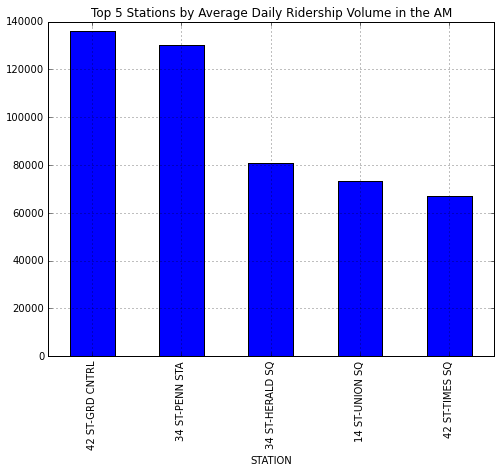

In [29]:
# Graph Top 5 AM stations by mean in descending order
df_am_groupby_stations.TOTAL_VOL.mean().order(ascending=False)[:5].plot(kind='bar',
                        title="Top 5 Stations by Average Daily Ridership Volume in the AM",
                        figsize=(8,6))

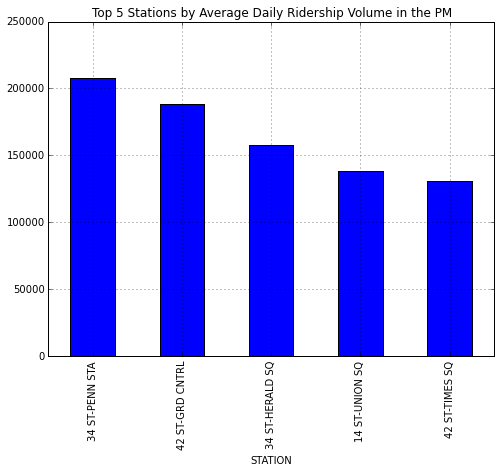

In [30]:
# Graph Top 5 PM stations by mean in descending order
df_pm_groupby_stations.TOTAL_VOL.mean().order(ascending=False)[:5].plot(kind='bar',
                            title="Top 5 Stations by Average Daily Ridership Volume in the PM",
                            figsize=(8,6))

In [41]:
df_merge_stations[df_merge_stations['R']=='Y'].STATION.unique().sort()

None
